![image](screenshot.png)

# Time-series Forecasting

## Description
The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by the following feature columns.

Your task is to **aggregate the observations on an interval of 30 minutes**. For this time interval, using the values of the **5 previous time intervals**, forecast the target value one step in the future. Choose which features you are going to use.

**You must train an LSTM network.**



Features:

* Datetime: Time window of ten minutes.
* Temperature: Weather Temperature.
* Humidity: Weather Humidity.
* WindSpeed: Wind Speed.
* GeneralDiffuseFlows: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* DiffuseFlows

Target:

PowerConsumption

## Dataset links:
 * [DS1](https://drive.google.com/file/d/1k5Ee9kla-0s8iuEASsSY2u5hl6YstzlN/view?usp=sharing)
 * [DS2](https://drive.google.com/file/d/1--Kep6SOWuyQ2FTlBDdwWHj-65bOl1kc/view?usp=sharing)

## Read the datasets

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense,Input
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [13]:
df_feature = pd.read_csv('../datasets/power_consumption_g1_feat.csv')
df_feature.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
0,2017-03-01 16:40:00,21.33,55.91,0.080,387.400,427.300
1,2017-07-27 06:30:00,23.10,48.58,4.908,10.450,8.630
2,2017-10-11 19:00:00,23.10,59.82,0.084,0.446,0.322
3,2017-02-10 06:50:00,12.25,80.80,4.916,0.051,0.111
4,2017-03-06 16:00:00,15.62,59.38,0.075,533.400,579.900


In [14]:
df_target = pd.read_csv('../datasets/power_consumption_g1.csv')
df_target.head()

,Datetime,PowerConsumption
0,2017-10-04 02:20:00,26802.27571
1,2017-05-28 13:20:00,32898.09836
2,2017-03-15 06:00:00,22304.68085
3,2017-10-31 11:40:00,32316.49891
4,2017-04-20 02:50:00,23982.43272


In [15]:
df_feature['Datetime'] = pd.to_datetime(df_feature['Datetime'])
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datetime             52416 non-null  datetime64[ns]
 1   Temperature          51857 non-null  float64       
 2   Humidity             51917 non-null  float64       
 3   WindSpeed            51887 non-null  float64       
 4   GeneralDiffuseFlows  51892 non-null  float64       
 5   DiffuseFlows         51911 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 2.4 MB


In [16]:
df_feature.set_index(keys=['Datetime'],inplace=True)
df_feature.sort_index(inplace=True)
df_feature.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
Datetime,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085


In [17]:
df_target['Datetime'] = pd.to_datetime(df_target['Datetime'])
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Datetime          52416 non-null  datetime64[ns]
 1   PowerConsumption  52416 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 819.1 KB


In [18]:
df_target.set_index(keys=['Datetime'],inplace=True)
df_target.sort_index(inplace=True)
df_target.head()

,PowerConsumption
Datetime,
2017-01-01 00:00:00,34055.69620
2017-01-01 00:10:00,29814.68354
2017-01-01 00:20:00,29128.10127
2017-01-01 00:30:00,28228.86076
2017-01-01 00:40:00,27335.69620


## Merge the datasets

In [19]:
df = pd.merge(left=df_feature,right=df_target,left_index=True,right_index=True)
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption
Datetime,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620


In [20]:
df.isnull().sum()

Temperature            559
Humidity               499
WindSpeed              529
GeneralDiffuseFlows    524
DiffuseFlows           505
PowerConsumption         0
dtype: int64

In [21]:
features = ["Temperature", "Humidity", "WindSpeed", "GeneralDiffuseFlows", "DiffuseFlows"]
target = "PowerConsumption"

In [22]:
for feature in features:
    df[feature] = df[feature].interpolate(method="linear")

In [23]:
df.isnull().sum()

Temperature            0
Humidity               0
WindSpeed              0
GeneralDiffuseFlows    0
DiffuseFlows           0
PowerConsumption       0
dtype: int64

## Group the datasets into time intervals of 30 mintues

In [24]:
df = df.groupby(pd.Grouper(freq='30min')).mean()
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption
Datetime,,,,,,
2017-01-01 00:00:00,6.428667,74.266667,0.082000,0.061000,0.101333,30999.493670
2017-01-01 00:30:00,5.941000,75.866667,0.081667,0.066000,0.096333,27396.455697
2017-01-01 01:00:00,5.605000,77.900000,0.082000,0.056333,0.110000,25407.594937
2017-01-01 01:30:00,5.492667,77.166667,0.082000,0.057333,0.115000,23906.835443
2017-01-01 02:00:00,5.000667,78.766667,0.082667,0.065000,0.127333,22474.936707


<Axes: xlabel='Datetime', ylabel='Temperature'>

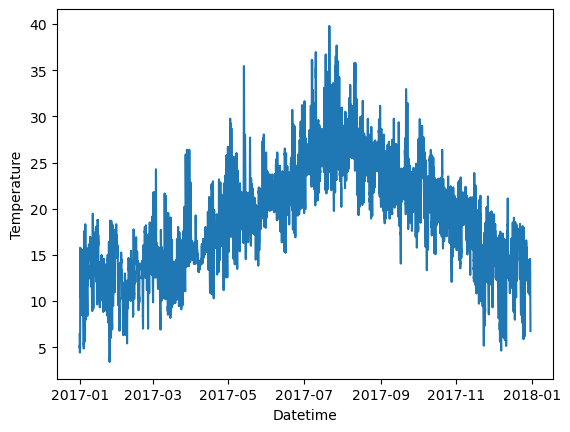

In [25]:
import seaborn as sns
sns.lineplot(df['Temperature'])

<Axes: xlabel='Datetime', ylabel='Humidity'>

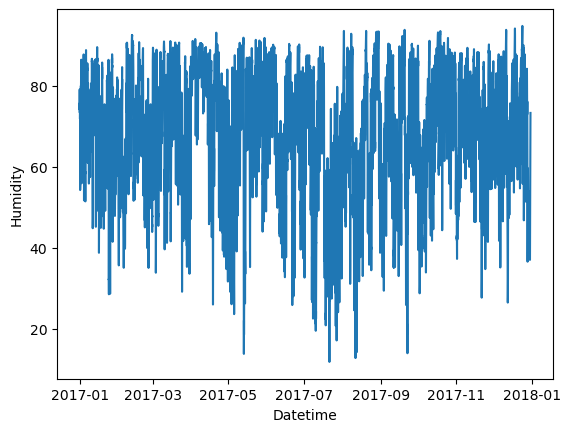

In [26]:
sns.lineplot(df['Humidity'])

<Axes: xlabel='Datetime', ylabel='WindSpeed'>

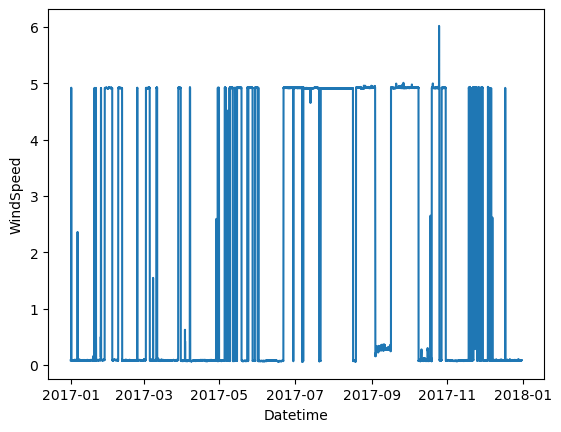

In [27]:
sns.lineplot(df['WindSpeed'])


<Axes: xlabel='Datetime', ylabel='GeneralDiffuseFlows'>

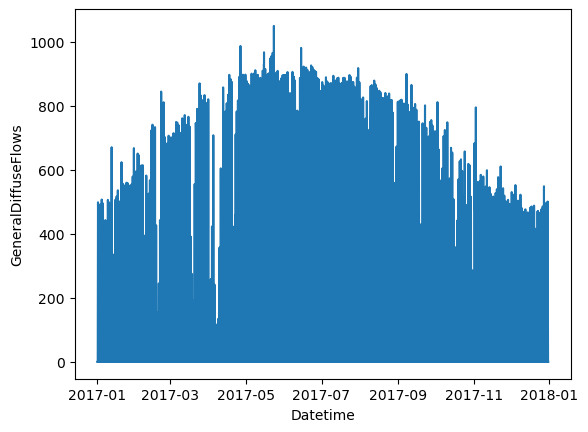

In [28]:
sns.lineplot(df['GeneralDiffuseFlows'])


<Axes: xlabel='Datetime', ylabel='DiffuseFlows'>

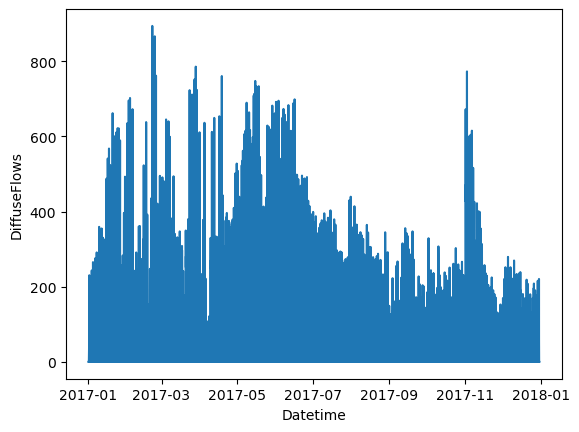

In [29]:
sns.lineplot(df['DiffuseFlows'])


<Axes: >

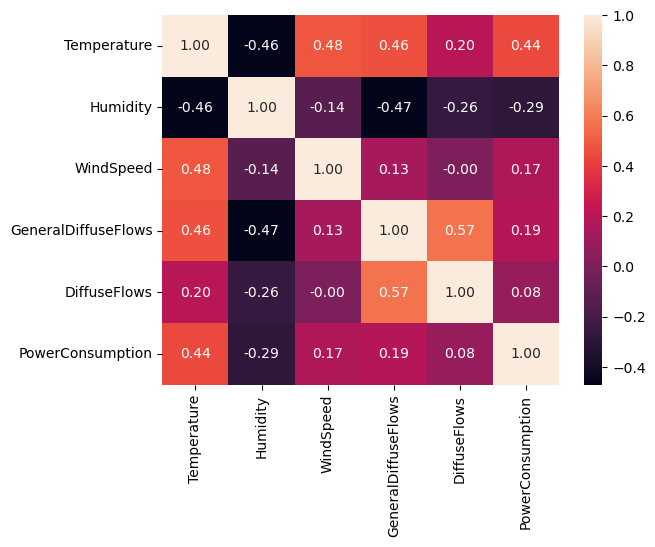

In [30]:
sns.heatmap(df.corr(),annot=True,fmt='.2f')

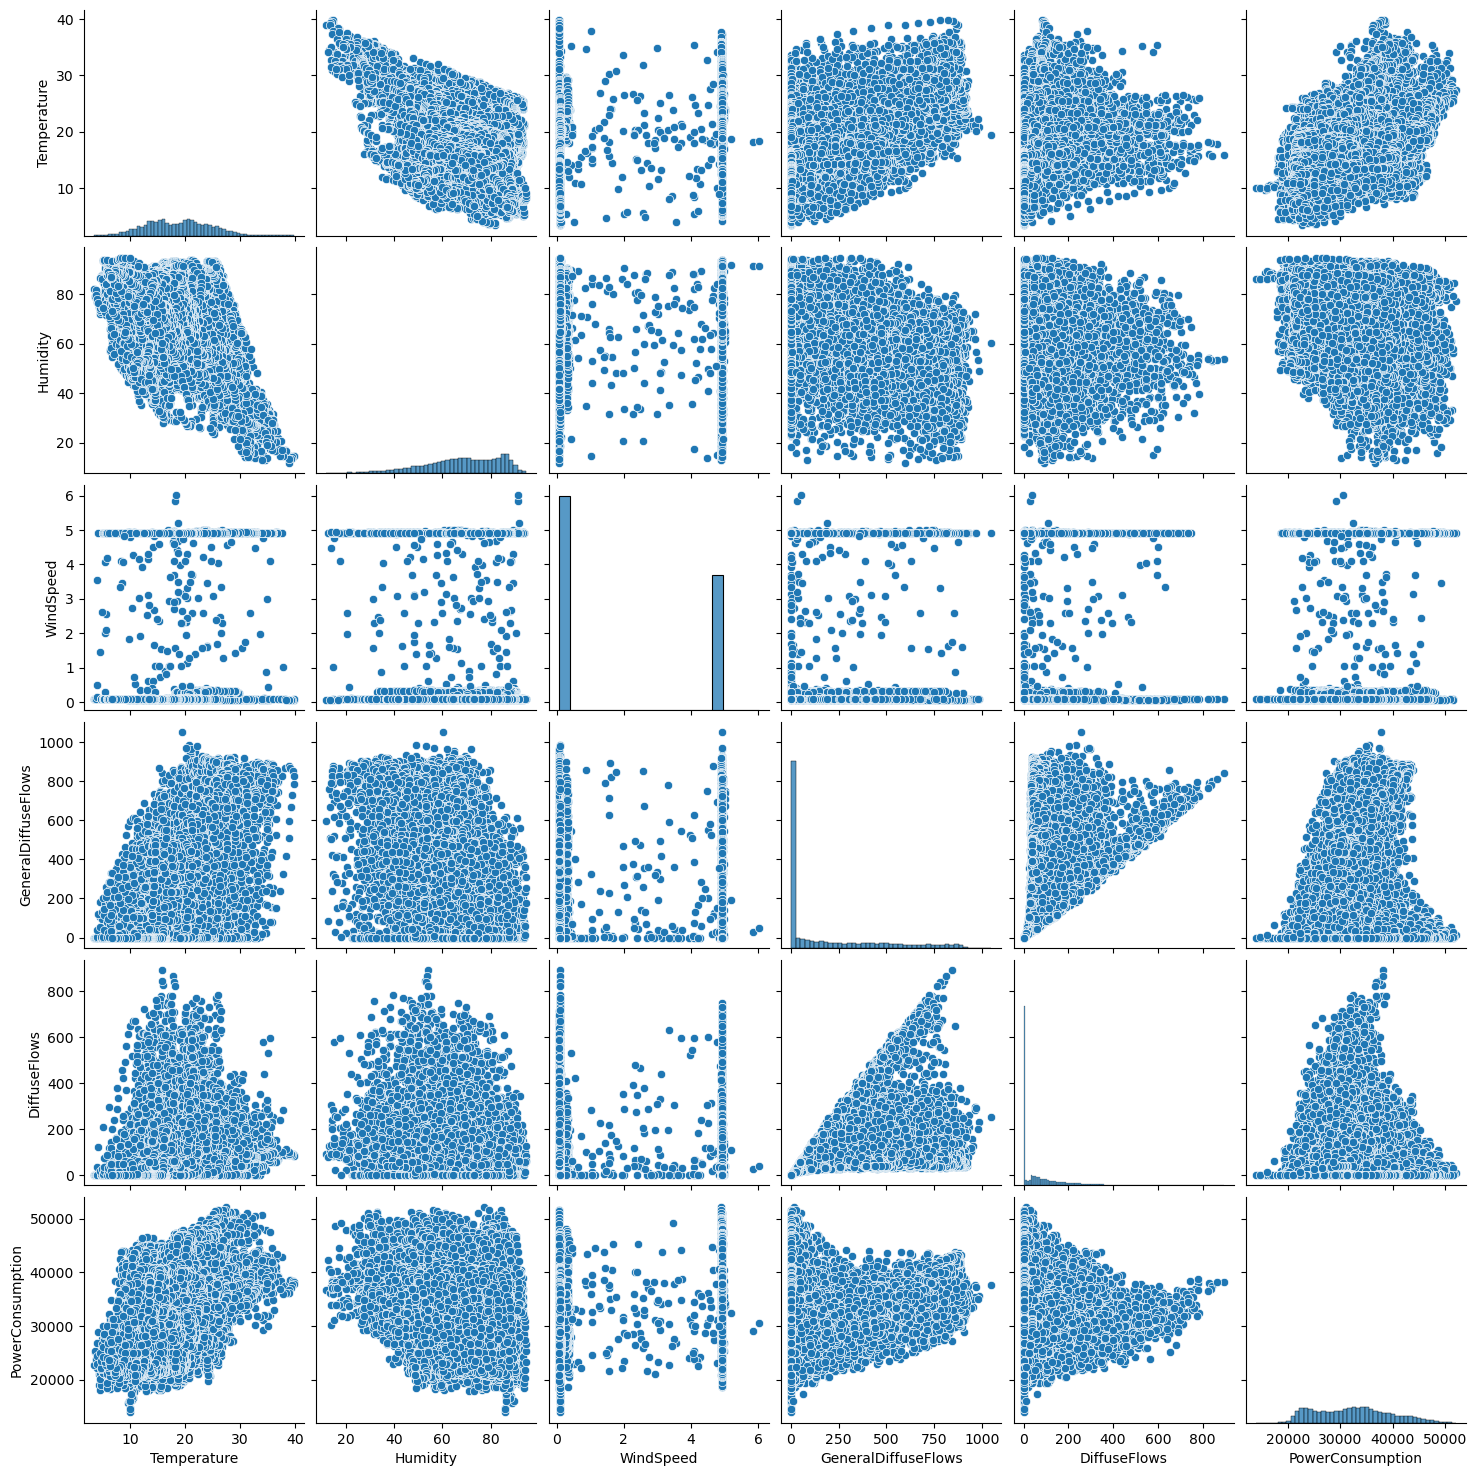

In [31]:
sns.pairplot(df)


## Create lags

In [32]:
lags = range(5, 0, -1)
list(lags)

[5, 4, 3, 2, 1]

In [50]:
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption
Datetime,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620


In [33]:
for lag in lags:
    for column in features + [target]:
        df[f'{column}_{lag}'] = df[column].shift(lag)
df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption,Temperature_5,Humidity_5,WindSpeed_5,GeneralDiffuseFlows_5,...,WindSpeed_2,GeneralDiffuseFlows_2,DiffuseFlows_2,PowerConsumption_2,Temperature_1,Humidity_1,WindSpeed_1,GeneralDiffuseFlows_1,DiffuseFlows_1,PowerConsumption_1
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.428667,74.266667,0.082000,0.061000,0.101333,30999.493670,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:30:00,5.941000,75.866667,0.081667,0.066000,0.096333,27396.455697,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.428667,74.266667,0.082000,0.061000,0.101333,30999.493670
2017-01-01 01:00:00,5.605000,77.900000,0.082000,0.056333,0.110000,25407.594937,NaN,NaN,NaN,NaN,...,0.082000,0.061000,0.101333,30999.493670,5.941000,75.866667,0.081667,0.066000,0.096333,27396.455697
2017-01-01 01:30:00,5.492667,77.166667,0.082000,0.057333,0.115000,23906.835443,NaN,NaN,NaN,NaN,...,0.081667,0.066000,0.096333,27396.455697,5.605000,77.900000,0.082000,0.056333,0.110000,25407.594937
2017-01-01 02:00:00,5.000667,78.766667,0.082667,0.065000,0.127333,22474.936707,NaN,NaN,NaN,NaN,...,0.082000,0.056333,0.110000,25407.594937,5.492667,77.166667,0.082000,0.057333,0.115000,23906.835443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 21:30:00,7.913333,70.343333,0.081667,0.069333,0.087667,34786.311787,9.710000,61.685000,0.075000,0.052667,...,0.086000,0.066000,0.090000,36846.641317,8.110000,69.006667,0.081333,0.077000,0.109000,35930.038023
2017-12-30 22:00:00,7.793333,69.563333,0.081000,0.062333,0.108667,34660.583017,9.196667,63.106667,0.074333,0.051333,...,0.081333,0.077000,0.109000,35930.038023,7.913333,70.343333,0.081667,0.069333,0.087667,34786.311787
2017-12-30 22:30:00,7.403333,71.066667,0.082667,0.055000,0.107667,33326.235743,8.933333,63.473333,0.074667,0.039333,...,0.081667,0.069333,0.087667,34786.311787,7.793333,69.563333,0.081000,0.062333,0.108667,34660.583017


In [34]:
df.drop(features,inplace=True,axis=1)

In [35]:
df.dropna(axis=0, inplace=True)

In [36]:
df

,PowerConsumption,Temperature_5,Humidity_5,WindSpeed_5,GeneralDiffuseFlows_5,DiffuseFlows_5,PowerConsumption_5,Temperature_4,Humidity_4,WindSpeed_4,...,WindSpeed_2,GeneralDiffuseFlows_2,DiffuseFlows_2,PowerConsumption_2,Temperature_1,Humidity_1,WindSpeed_1,GeneralDiffuseFlows_1,DiffuseFlows_1,PowerConsumption_1
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 02:30:00,21691.139240,6.428667,74.266667,0.082000,0.061000,0.101333,30999.493670,5.941000,75.866667,0.081667,...,0.082000,0.057333,0.115000,23906.835443,5.000667,78.766667,0.082667,0.065000,0.127333,22474.936707
2017-01-01 03:00:00,20992.405063,5.941000,75.866667,0.081667,0.066000,0.096333,27396.455697,5.605000,77.900000,0.082000,...,0.082667,0.065000,0.127333,22474.936707,5.108000,79.100000,0.082000,0.061000,0.131000,21691.139240
2017-01-01 03:30:00,20629.873417,5.605000,77.900000,0.082000,0.056333,0.110000,25407.594937,5.492667,77.166667,0.082000,...,0.082000,0.061000,0.131000,21691.139240,5.097000,77.600000,0.082667,0.059667,0.130000,20992.405063
2017-01-01 04:00:00,20512.405063,5.492667,77.166667,0.082000,0.057333,0.115000,23906.835443,5.000667,78.766667,0.082667,...,0.082667,0.059667,0.130000,20992.405063,4.911667,76.566667,0.083000,0.060000,0.152000,20629.873417
2017-01-01 04:30:00,20439.493670,5.000667,78.766667,0.082667,0.065000,0.127333,22474.936707,5.108000,79.100000,0.082000,...,0.083000,0.060000,0.152000,20629.873417,4.952333,74.733333,0.083667,0.058667,0.117333,20512.405063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 21:30:00,34786.311787,9.710000,61.685000,0.075000,0.052667,0.108667,37690.240813,9.196667,63.106667,0.074333,...,0.086000,0.066000,0.090000,36846.641317,8.110000,69.006667,0.081333,0.077000,0.109000,35930.038023
2017-12-30 22:00:00,34660.583017,9.196667,63.106667,0.074333,0.051333,0.095333,37337.389100,8.933333,63.473333,0.074667,...,0.081333,0.077000,0.109000,35930.038023,7.913333,70.343333,0.081667,0.069333,0.087667,34786.311787
2017-12-30 22:30:00,33326.235743,8.933333,63.473333,0.074667,0.039333,0.120000,37171.102660,9.150000,64.506667,0.086000,...,0.081667,0.069333,0.087667,34786.311787,7.793333,69.563333,0.081000,0.062333,0.108667,34660.583017


# Split the dataset into 80% training and 20% testing datasets

In [41]:
X = df.drop(columns=target,axis=1)
y = df[target]
y

Datetime
2017-01-01 02:30:00    21691.139240
2017-01-01 03:00:00    20992.405063
2017-01-01 03:30:00    20629.873417
2017-01-01 04:00:00    20512.405063
2017-01-01 04:30:00    20439.493670
                           ...     
2017-12-30 21:30:00    34786.311787
2017-12-30 22:00:00    34660.583017
2017-12-30 22:30:00    33326.235743
2017-12-30 23:00:00    31249.683140
2017-12-30 23:30:00    28966.286437
Freq: 30min, Name: PowerConsumption, Length: 17467, dtype: float64

In [43]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

In [44]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(13973, 30) (3494, 30) (13973,) (3494,)


## Create the model, pre-process the data and make it suitable for training

In [47]:
x_scaler = MinMaxScaler()
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)

In [49]:
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.to_numpy().reshape(-1,1))

In [53]:
lag = 5
x_train.shape[1] % lag

0

In [60]:
x_train = x_train.reshape(x_train.shape[0],lag,(x_train.shape[1]//lag))
x_test = x_test.reshape(x_test.shape[0],lag,(x_test.shape[1]//lag))

In [62]:
print(x_train.shape)

(13973, 5, 6)


In [61]:
model = Sequential()

In [63]:
model.add(Input(shape=(x_train.shape[1],x_train.shape[2])))
model.add(LSTM(units=64,activation='relu',return_sequences=True))
model.add(LSTM(units=32,activation='relu'))
model.add(Dense(units=1,activation='linear'))

W0000 00:00:1737121462.495271   10774 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [64]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 64)          │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model, use 20% of the training dataset for validation
Train with 10 epochs (due to time limit)

In [65]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)

In [66]:
history = model.fit(x_train,y_train,epochs=10,validation_split=0.2,shuffle=False)

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.00

## Plot the loss function on the training and validation dataset

<Axes: >

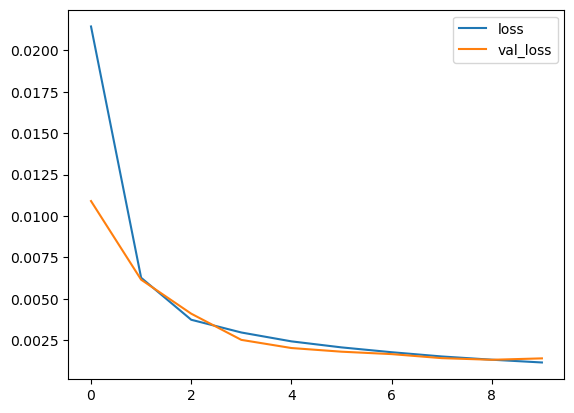

In [68]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

## Calculate the adequate metrics

In [71]:
y_pred = model.predict(x_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [72]:
y_pred = y_scaler.inverse_transform(y_pred)

In [74]:
print(f'Mean Squared Error:{mean_squared_error(y_test,y_pred)}')
print(f'Mean Absolute Error:{mean_absolute_error(y_test,y_pred)}')
print(f'R2 Score:{r2_score(y_test,y_pred)}')

Mean Squared Error:1434061.3343618615
Mean Absolute Error:903.7482914771155
R2 Score:0.9621148836921092


## Visualize the targets against the predictions

<Axes: xlabel='Datetime'>

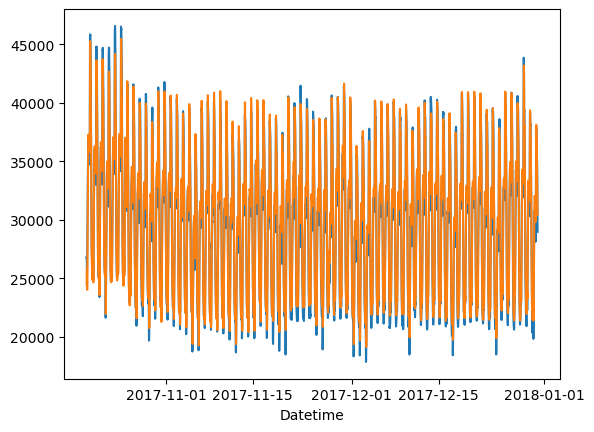

In [77]:
sns.lineplot(x=y_test.index, y=y_test.values)
sns.lineplot(x=y_test.index, y=y_pred.flatten())